<a href="https://colab.research.google.com/github/TemrinaDarya/turbines-2022/blob/hw-4/hw_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

По аналогии с решением задач из практики, построить график зависимости $\eta_{oi} = f(H_0)$ в диапазоне $H_0$ = (50 - 150) $\frac {kJ}{kg}$. $\eta_{ол}$ = 78%. $u = 160 m/s$. Все остальные переменные и условия принять такие же как на практическом заняти.

In [ ]:
!pip install iapws

import iapws
from iapws import IAPWS97 as gas
import math
import matplotlib.pyplot as plt
import numpy as np

MPa = 10 ** 6
kPa = 10 ** 3
unit = 1 / MPa
to_kelvin = lambda x: x + 273.15 if x else None



In [2]:
#Исходные данные
p = 5 * MPa
t = to_kelvin(489)
H_0 = range(50,150)
u = 160
F1 = 0.025
d_r = 1.09
s_div_r = 0.2 
degree__of_reaction = 0.1
z_bandage = 2
delta_r_bandage = 1.17 / 1000
delta_a_bandage = 4 / 1000
z_rotor = 5
d_leak_rotor = 0.36
delta_leak_rotor = 0.4 / 1000
e = 0.8
sin_alpha_1 = 0.225
blade_width = 0.035
blade_length = 0.035
blade_efficiency = 0.78
segments = 4
m = 1
k = 0.065
mu_a = 0.5 
mu_r = 0.8 
K_y = 1 
mu_r_rotor = 0.8
mu_nozzle = 0.97 

point = gas(P=p * unit, T=t)
kinematic_viscosity = point.nu 

In [3]:
def get_Re_number(u, d_r):
    Re_number = u * d_r * 0.5 / kinematic_viscosity
    return Re_number


def get_k_frictions(s_div_r, Re_number):
    k_f = 2.5 * 10 ** (-2) * s_div_r ** 0.1 * Re_number ** (-0.2)
    return k_f


def get_friction_loss_pu(k_f, d_r, u_div_dummy_speed, F1):
    friction_loss_pu = k_f * d_r ** 2 * u_div_dummy_speed ** 3 / F1
    return friction_loss_pu


def get_ventilation_loss_pu(m, k, sin_alpha_1, e, u_div_dummy_speed):
    first = k / sin_alpha_1
    second = (1 - e) / e
    third = u_div_dummy_speed ** 3
    ventilation_loss_pu = first * second * third * m
    return ventilation_loss_pu


def get_segment_loss_pu(blade_width, blade_length, F1, u_div_dummy_speed, blade_efficiency, segments):
    B = blade_width
    l = blade_length
    F = F1
    first = 0.25 * B * l / F
    second = u_div_dummy_speed * blade_efficiency * segments
    segment_loss_pu = first * second
    return segment_loss_pu




def compute_equal_gap(z_bandage, delta_r_bandage, mu_r_rotor, delta_a_bandage, mu_a):
    z = z_bandage
    delta_r = delta_r_bandage
    delta_a = delta_a_bandage
    first = 1 / (mu_a * delta_a) ** 2
    second = z / (mu_r_rotor * delta_r) ** 2
    equal_gap = (first + second) ** (-0.5)
    return equal_gap


def get_bandage_leak_loss_pu(delta_r_bandage, equal_gap, F1, degree__of_reaction, blade_length, blade_efficiency):
    l = blade_length
    dor = degree__of_reaction
    delta_eq = equal_gap
    d_shroud = delta_r_bandage / 0.001
    d_avg = d_shroud - l
    first = math.pi * d_shroud * delta_eq / F1
    second = dor + 1.8 * (l / d_avg)
    bandage_leak_loss_pu = first * (second) ** 0.5 * blade_efficiency
    return bandage_leak_loss_pu


def get_disk_leak_loss_pu(K_y, d_leak_rotor, delta_leak_rotor, mu_r, mu_nozzle, F1, z_rotor, blade_efficiency):
    F_leak_rotor = math.pi * d_leak_rotor * delta_leak_rotor
    upper = mu_r * K_y * F_leak_rotor * blade_efficiency
    lower = mu_nozzle * F1 * z_rotor ** 0.5
    disk_leak_loss_pu = upper / lower
    return disk_leak_loss_pu


def count_internal_efficiency(H_value):
    H_value = H_value * 1000
    dummy_speed = (2 * H_value) ** 0.5
    u_div_dummy_speed = u / dummy_speed

    Re_number = get_Re_number(u, d_r)
    k_f = get_k_frictions(s_div_r, Re_number)
    friction_loss_pu = get_friction_loss_pu(k_f, d_r, u_div_dummy_speed, F1)
    ventilation_loss_pu = get_ventilation_loss_pu(m, k, sin_alpha_1, e, u_div_dummy_speed)
    segment_loss_pu = get_segment_loss_pu(blade_width, blade_length, F1, u_div_dummy_speed, blade_efficiency, segments)
    partial_losses_pu = segment_loss_pu + ventilation_loss_pu
    equal_gap = compute_equal_gap(z_bandage, delta_r_bandage, mu_r_rotor, delta_a_bandage, mu_a)
    disk_leak_loss_pu = get_disk_leak_loss_pu(K_y, d_leak_rotor, delta_leak_rotor, mu_r, mu_nozzle, F1, z_rotor,
                                              blade_efficiency)
    bandage_leak_loss_pu = get_bandage_leak_loss_pu(delta_r_bandage, equal_gap, F1, degree__of_reaction, blade_length,
                                                    blade_efficiency)
    leak_losses_pu = disk_leak_loss_pu + bandage_leak_loss_pu
    internal_efficiency = blade_efficiency - friction_loss_pu - partial_losses_pu - leak_losses_pu
    return internal_efficiency

In [4]:
internal_efficiencies = []
for H_value in H_0:
    internal_efficiency = count_internal_efficiency(H_value)
    internal_efficiencies.append(internal_efficiency)

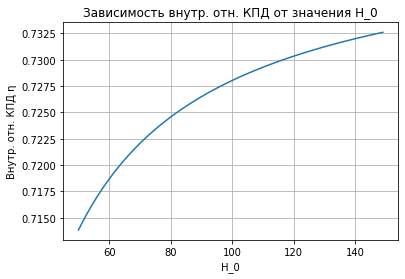

In [5]:
plt.plot(H_0, internal_efficiencies)
plt.xlabel('H_0')
plt.ylabel('Внутр. отн. КПД η')
plt.title("Зависимость внутр. отн. КПД от значения H_0")
plt.grid()

plt.show()